In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import DataLoader
import random
import pickle
import networkx as nx
import os
from PIL import Image
import cv2
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

In [37]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# NUMBER_NODES = 10
# NUMBER_NODES = 9
NUMBER_NODES = 7
# NUMBER_NODES = 5
# DATASET_PATH = f'./opt_band_{NUMBER_NODES}_nodes_graph.csv'
DATASET_PATH = f'../../../../datasets/examples/opt_band_{NUMBER_NODES}_nodes_graph.csv'

In [38]:
def getArray(strArray):
    arr = strArray.split('.')
    first = strArray[1]
    arr = [first, *arr[1 : -1]] # skip '[' and ']'
    arr = list(map(lambda x: int(x.strip()), arr))
    return np.array(arr)

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = read_image(img_path)
        image = image / 255
        label = self.img_labels.iloc[idx, 1]
        label = torch.from_numpy(getArray(label))
        return image, label

In [39]:
training_data = CustomImageDataset(annotations_file='./annotations_file_train.csv', img_dir='./dataset_7')
val_data = CustomImageDataset(annotations_file='./annotations_file_val.csv', img_dir='./dataset_val_7')

In [40]:
BATCH_SIZE = 4
train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
torch.Size([4, 3, 32, 32])
torch.Size([4, 7])


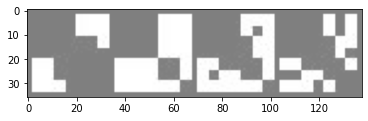

tensor([3, 5, 0, 4, 1, 6, 2], dtype=torch.int32) tensor([1, 0, 6, 4, 5, 3, 2], dtype=torch.int32) tensor([3, 2, 5, 6, 0, 4, 1], dtype=torch.int32) tensor([1, 4, 6, 0, 2, 3, 5], dtype=torch.int32)


In [41]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

print(type(images))
print(type(images[0]))
print(type(images[0][0]))
print(images.shape)
print(labels.shape)

# # show images
imshow(torchvision.utils.make_grid(images))
# # print labels
print(' '.join('%5s' % labels[j] for j in range(BATCH_SIZE)))

In [42]:
class CustomLoss(torch.nn.Module):
    
    def __init__(self):
        super(CustomLoss,self).__init__()
    
    def loss_repeated_labels(self, output):
      used_labels, counts = torch.unique(output, return_counts=True)
      counts = counts.type(torch.DoubleTensor)
      diffLabelCounts = (output.shape[0] - counts.shape[0])**2
      sampleVariance = torch.var(counts, unbiased=False)

      return sampleVariance + diffLabelCounts

    def forward(self, output, target):
      # print(output.shape)
      # print(target[ : , : 1].shape)
      loss_mse = ((output - target[ : , : 1])**2).mean()
      roundedOutput = output.round()
      loss_repeated = self.loss_repeated_labels(roundedOutput)
      return loss_mse + loss_repeated

teste = CustomLoss()
y_pred = torch.tensor([[1., 1., 1., 1., 1., 1., 1.]])
#y_pred = torch.tensor([0., 1., 1., 2., 2., 3., 1.])
#y_pred = torch.tensor([0., 1., 2., 3., 4., 5., 6.])
y_true = torch.tensor([[0., 0., 1., 2., 3., 4., 5., 6.]])
teste.forward(y_pred, y_true)

tensor(1., dtype=torch.float64)

In [43]:
def train(dataloader, model, optimizer):
    criterion = CustomLoss()
    # criterion = nn.MSELoss()
    # model.train()
    train_loss = 0
    for X, y in dataloader:
        pred = model(X)
        # one = torch.nn.functional.one_hot(target, num_classes=3)
        # one = one.type(torch.float32)
        # print("FELIPE")
        # print(X.shape)
        # print(pred.shape)
        # print(pred)
        # print(y.shape)
#         FELIPE
# torch.Size([4, 3, 32, 32])
# torch.Size([7])
# torch.Size([4, 7])
        loss = criterion(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    return (train_loss / len(dataloader))

def validation(dataloader, model):
    criterion = CustomLoss()
    train_loss = 0
    for X, y in dataloader:
        pred = model(X)
        loss = criterion(pred, y)
        train_loss += loss.item()

    return (train_loss / len(dataloader))

In [44]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [45]:
epochs = 128

model = Net()

optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)

list_train_loss = []
list_val_loss = []

for epoch in range(epochs):
    train_loss = train(train_dataloader, model, optimizer)
    list_train_loss.append(train_loss)
    val_loss = validation(val_dataloader, model)
    list_val_loss.append(val_loss)
    print(f'Epoch {epoch + 1}, train_loss: {train_loss}, val_loss: {val_loss}')


Epoch 1, train_loss: 23.020882360605484, val_loss: 92.34514996638664
Epoch 2, train_loss: 54.331795338723566, val_loss: 24.74454984957209
Epoch 3, train_loss: 32.894993600256335, val_loss: 41.12654645425769
Epoch 4, train_loss: 36.118469663193316, val_loss: 27.679871832808622
Epoch 5, train_loss: 29.521659036590137, val_loss: 36.80236665446024
Epoch 6, train_loss: 37.07155151438347, val_loss: 20.69988662749529
Epoch 7, train_loss: 40.83489172814445, val_loss: 46.022247082912
Epoch 8, train_loss: 41.622346900301324, val_loss: 35.349076598882675
Epoch 9, train_loss: 42.70443952151224, val_loss: 37.29937034845352
Epoch 10, train_loss: 47.279511307817536, val_loss: 38.235287281756214
Epoch 11, train_loss: 39.38867965370908, val_loss: 45.90259359433101
Epoch 12, train_loss: 39.48459846992793, val_loss: 34.99310421746256
Epoch 13, train_loss: 42.12102325195114, val_loss: 34.90760202858692
Epoch 14, train_loss: 35.018247883553755, val_loss: 33.25342529993027
Epoch 15, train_loss: 45.232234659

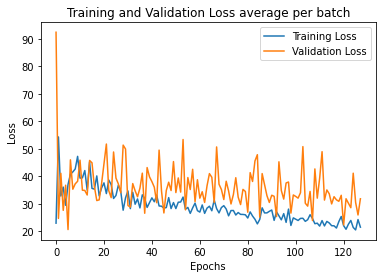

<Figure size 432x288 with 0 Axes>

In [46]:
plt.plot(list_train_loss, label='Training Loss')
plt.plot(list_val_loss, label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss average per batch')
# plt.savefig(os.path.join(os.path.dirname(__file__), 'loss3.jpg'))
plt.show()
plt.clf()

In [47]:
print("Test dataloader")
for x, y in val_dataloader:
  print(x.shape)
  pred = model(x).round()
  print("=============")
  print('pred:', pred)
  print('y:', y[:,1:])
  break
print("Train dataloader")
for x, y in train_dataloader:
  print(x.shape)
  pred = model(x).round()
  print("=============")
  print('pred:', pred)
  print('y:', y[:,1:])
  break
# load the last checkpoint with the best model
# model.load_state_dict(torch.load('checkpoint.pt'))

Test dataloader
torch.Size([4, 3, 32, 32])
pred: tensor([[0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., -0., 0.],
        [1., 0., 0., 1., 1., 1., 1.],
        [3., 3., 3., 3., 3., 3., 3.]], grad_fn=<RoundBackward>)
y: tensor([[6, 2, 0, 5, 3, 4],
        [6, 0, 5, 3, 4, 2],
        [5, 6, 0, 3, 2, 4],
        [5, 1, 0, 6, 4, 3]], dtype=torch.int32)
Train dataloader
torch.Size([4, 3, 32, 32])
pred: tensor([[1., 0., 0., 0., 0., 0., 0.],
        [3., 3., 3., 3., 3., 3., 3.],
        [2., 2., 2., 2., 3., 2., 2.],
        [2., 2., 2., 2., 2., 2., 2.]], grad_fn=<RoundBackward>)
y: tensor([[6, 0, 5, 3, 2, 4],
        [2, 0, 5, 1, 6, 3],
        [5, 1, 0, 4, 6, 3],
        [1, 4, 6, 5, 0, 3]], dtype=torch.int32)
